# Odločitveni sistemi - 1. seminarska - Odločitveni model
## Tema: Izbira nove grafične kartice

Avtor: Luka Šveigl (63200301)

### Kazalo

1. Uvod
2. Podatki <br>
    1. Hierarhično drevo
    2. Priprava podatkov
    3. Pregled podatkov
3. Uteži in funkcije koristnosti
    1. Funkcije koristnosti
    2. Uteži
    3. Prikaz kriterijev in uteži
       1. Prikaz kriterijev
       2. Prikaz uteži
4. Ocene variant
5. Analiza
6. Kaj-če analiza
7. Reference  

### Uvod

Za problem izbire grafične kartice sem se odločil, ker se že nekaj časa soočam z dejstvom da moram kmalu nadgraditi svoj računalnik in se mi zdi,
da je grafična kartica ena izmed najpomembnejših (in verjetno najdražjih) komponent. Prav zaradi tega dejstva sem izbral to tematiko, saj menim, 
da mi lahko olajša težko izbiro.

### Podatki

V izboru imam na začetku 50 najpopularnejših grafičnih kartic v zadnjih letih, podatke o katerih sem pridobil iz spletne strani techpowerup.com 
(na voljo na povezavi: [https://www.techpowerup.com/gpu-specs/](https://www.techpowerup.com/gpu-specs/)). Tem podatkom sem dodal še ceno v dolarjih,
 katero sem pridobil iz spletne strani newegg.com (na voljo na povezavi: [https://www.newegg.com/](https://www.newegg.com/)), in razdelil podatke o Senčilnikih, 
TMU ter ROP na 3 različne kriterije. Ker bom nadgrajeval celotni računalnik, sem se odločil, da izbire ne bom omejeval glede na povezljivost z
matično ploščo, saj bo le ta izbrana po izbiri grafične kartice, in ne obratno. Te podatke bom tekom seminarske tudi prilagajal (npr. znebil se 
kartic katerih cena ni poznana, kartic, ki še niso izšle ipd.). 

#### Hierarhično drevo

Hierarhično drevo je sestavljeno iz 11 kriterijev ter 5 izpeljanih vozlišč.
- Kriteriji Bus, Memory in Memory clock sta združena v vozlišče Bandwith, ki predstavlja mero prenosa podatkov v spominu.
- Kriteriji Shaders, TMUs, ROPs so združeni v vozlišče Rendering, ki predstavlja zmožnost uprizoritve grafične kartice.
- Kriterija GPU clock in GPU chip sta združena v vozlišče Chipset, ki predstavlja zmogljivost glavnega čipa grafične kartice.
- Vozlišča Bandwith, Rendering in Chipset so združena v vozlišče Performance, ki predstavlja celotno zmogljivost.
- Kriterija Release in Price sta združena v vozlišče Value per time, ki predstavlja vrednost kartice glede na čas.
- Vozlišči Performance in Value per time ter kriterij Manufacturer so združeni v vozlišče GPU, ki predstavlja celotno grafično kartico.

![Hierarhicno drevo](resources/hierarchy%20tree.png)<br>
(Slika 1: Hierarhično drevo)

#### Priprava podatkov

In [236]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as mp
from matplotlib import pyplot as plt

data = pd.read_csv('data.csv', encoding='utf-8', sep=';')

# Remove GPUs with unknown price.
data = data[pd.notna(data.Price)]

# Remove unreleased GPUs. This means removing records with
# only the year as their release date.
data = data[data.Released.apply(lambda x : len(x) != 4)]

##### Pregled podatkov

Spodaj je prikazanih prvih 5 vrstic popravljenega podatkovnega okvirja.

In [237]:
data.head(5)

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders,TMUs,ROPs,Price,Manufacturer
0,GeForce RTX 4090,AD102,"September 20, 2022",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",2235 MHz,1313 MHz,16384,512,176,2699.00,NVIDIA
3,GeForce RTX 3060,GA106,"January 12, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584,112,48,369.39,NVIDIA
4,GeForce RTX 3060 Ti,GA104,"December 1, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864,152,80,449.99,NVIDIA
5,GeForce RTX 3070,GA104,"September 1, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1500 MHz,1750 MHz,5888,184,96,549.99,NVIDIA
6,Radeon RX 580,Polaris 20,"April 18, 2017",PCIe 3.0 x16,"8 GB, GDDR5, 256 bit",1257 MHz,2000 MHz,2304,144,32,402.26,AMD


Spodaj so prikazani kriteriji, glede na katere bo model izbiral.

In [238]:
count = 0
for criteria in data.columns:
    if criteria != 'Product Name':
        if count < len(data.columns) - 1:
            print(criteria, end=', ')
        elif count == len(data.columns) - 1:
            print(criteria, end='')
    count += 1

GPU Chip, Released, Bus, Memory, GPU clock, Memory clock, Shaders, TMUs, ROPs, Price, Manufacturer

Spodaj je prikazanih 10 variant, oziroma grafičnih kartic, ki so v izboru.

In [239]:
count = 0
for variant in data['Product Name']:
    if count < 9:
        print(variant, end=', ')
    elif count == 9:
        print(variant, end='')
    count += 1

GeForce RTX 4090, GeForce RTX 3060, GeForce RTX 3060 Ti, GeForce RTX 3070, Radeon RX 580, GeForce RTX 2060, GeForce RTX 3080, Radeon RX 6600, Radeon RX 6700 XT, Radeon RX 6600 XT

### Uteži in funkcije koristnosti

#### Funkcije koristnosti

Spodaj so prikazane funkcije, ki pretvorijo vrednosti kriterijev v koristnosti, kar pomeni, da pretvorijo vse kriterije na isti razpon med 0 in 100. 
To storim tako, da zvezne kriterije normaliziram na skalo 0 = najslabše, 100 = najboljše. Pri diskretnih vrednostih pa sem vrednosti razdelil na enakomerne
intervale med 0 in 100.
<br>
Pri kriteriju GPU Chip sem podatke, ki so mi pomagali pri razvrščanju čipov, pridobil iz spletne strani technical city (dostopna na: [https://technical.city/en/video](https://technical.city/en/video))

In [240]:
# First set or calculate appropriate max and min values for certain ranges.
# This is done to increase performance, because the values do not have to be
# calculated on each function call.
new_scale_min_r = 100
new_scale_max_r = 0

new_scale_min = 0
new_scale_max = 100

max_memory_gb = max([int(i.split(',')[0][:2].replace(' ', '')) for i in data['Memory']])
min_memory_gb = min([int(i.split(',')[0][:2].replace(' ', '')) for i in data['Memory']])

max_memory_bits = max([int(i.split(',')[2][:4].replace(' ', '')) for i in data['Memory']])
min_memory_bits = min([int(i.split(',')[2][:4].replace(' ', '')) for i in data['Memory']])

max_bus_version = max([float(i.split(' ')[1]) for i in data['Bus']])
min_bus_version = min([float(i.split(' ')[1]) for i in data['Bus']])

max_bus_channels = max([int(i.split(' ')[2][-2:].replace('x', '')) for i in data['Bus']])
min_bus_channels = min([int(i.split(' ')[2][-2:].replace('x', '')) for i in data['Bus']])

max_release_date = max([datetime.datetime.strptime(i, "%B %d, %Y").date() for i in data['Released']])
min_release_date = min([datetime.datetime.strptime(i, "%B %d, %Y").date() for i in data['Released']])

def normalize_price(val : float) -> float:
    """ 
    Normalizes the GPU price on a scale of \n
    100 to 0.
    
    :param val: The price of the GPU.
    """
    if val == min(data.Price):
        return 100
    if val == max(data.Price):
        return 0
    return ((val - min(data.Price)) * (new_scale_max_r - new_scale_min_r)) / (max(data.Price) - min(data.Price)) + new_scale_min_r
    
    
def normalize_GPU_clock(val : str) -> float:
    """
    Normalizes the GPU clock on a scale of \n
    0 to 100.
    
    :param val: The GPU clock speed.
    """
    numeric_clocks = pd.to_numeric(data['GPU clock'].str[:4], errors='coerce').tolist()
    val = int(val[:4])
    if val == min(numeric_clocks):
        return 0
    if val == max(numeric_clocks):
        return 100
    return ((val - min(numeric_clocks)) * (new_scale_max - new_scale_min)) / (max(numeric_clocks) - min(numeric_clocks)) + new_scale_min
    
    
def normalize_memory_clock(val : str) -> float:
    """
    Normalizes the memory clock on a scale of \n
    0 to 100.
    
    :param val: The memory clock speed.
    """
    numeric_clocks = pd.to_numeric(data['Memory clock'].str[:4], errors='coerce').tolist()
    val = int(val[:4])
    if val == min(numeric_clocks):
        return 0
    if val == max(numeric_clocks):
        return 100
    return ((val - min(numeric_clocks)) * (new_scale_max - new_scale_min)) / (max(numeric_clocks) - min(numeric_clocks)) + new_scale_min


def normalize_shaders(val : float) -> float:
    """
    Normalizes the shaders on a scale of \n
    0 to 100.
    
    :param val: The shaders.
    """
    if val == min(data['Shaders']):
        return 0
    if val == max(data['Shaders']):
        return 100
    return ((val - min(data['Shaders'])) * (new_scale_max - new_scale_min)) / (max(data['Shaders']) - min(data['Shaders'])) + new_scale_min


def normalize_TMUs(val : float) -> float:
    """
    Normalizes the TMUs on a scale of \n
    0 to 100.
    
    :param val: The TMUs.
    """
    if val == min(data['TMUs']):
        return 0
    if val == max(data['TMUs']):
        return 100
    return ((val - min(data['TMUs'])) * (new_scale_max - new_scale_min)) / (max(data['TMUs']) - min(data['TMUs'])) + new_scale_min


def normalize_ROPs(val : float) -> float:
    """
    Normalizes the ROPs on a scale of \n
    0 to 100.
    
    :param val: The ROPs.
    """
    if val == min(data['ROPs']):
        return 0
    if val == max(data['ROPs']):
        return 100
    return ((val - min(data['ROPs'])) * (new_scale_max - new_scale_min)) / (max(data['ROPs']) - min(data['ROPs'])) + new_scale_min


def normalize_manufacturer(val : str) -> float:
    """
    Normalizes the ROPs on a scale of \n
    0 to 100.
    
    :param val: The ROPs.
    """
    if val == 'AMD':
        return 0
    if val == 'NVIDIA':
        return 100
    
    
def normalize_memory(val : str) -> float:
    """
    Normalizes the memory string on a scale of \n
    0 to 100, by dividing it into 3 components: \n
    size, ram, and bits, linearly evaluating those \n
    components and averaging them.
    
    :param val: The memory value.
    """
    size = int(val.split(',')[0][:2])
    ram = val.split(',')[1][-2:].replace('R', '')
    bits = int(val.split(',')[2][:4].replace(' ', ''))
    
    ram_modifier = 0
    if ram == '6X':
        ram_modifier = 100
    elif ram == '6':
        ram_modifier = 66
    elif ram == '5X':
        ram_modifier = 33
    size_modifier = ((size - min_memory_gb) * (new_scale_max - new_scale_min)) / (max_memory_gb - min_memory_gb) + new_scale_min
    bits_modifier = ((bits - min_memory_bits) * (new_scale_max - new_scale_min)) / (max_memory_bits - min_memory_bits) + new_scale_min   
     
    return (ram_modifier + size_modifier + bits_modifier) / 3


def normalize_bus(val : str) -> float:
    """
    Normalizes the bus string on a scale of \n
    0 to 100, by dividing it into 2 components: \n
    version and channels, linearly evaluating those \n
    components and averaging them.
    
    :param val: The bus value.
    """
    bus_version = float(val.split(' ')[1])
    bus_channels = int(val.split(' ')[2][-2:].replace('x', ''))
    
    version_modifier = ((bus_version - min_bus_version) * (new_scale_max - new_scale_min)) / (max_bus_version - min_bus_version) + new_scale_min
    channels_modifier = ((bus_channels - min_bus_channels) * (new_scale_max - new_scale_min)) / (max_bus_channels - min_bus_channels) + new_scale_min
    
    return (version_modifier + channels_modifier) / 2


def normalize_released(val : str) -> float:
    """
    Normalizes the date string on a scale of \n
    0 to 100.
    
    :param val: The date value.
    """
    
    return ((datetime.datetime.strptime('September 11, 2018', "%B %d, %Y").date() - min_release_date).days * (new_scale_max - new_scale_min)) / \
    (max_release_date - min_release_date).days + new_scale_min


def normalize_GPU_chip(val : str) -> float:
    """
    Normalizes the GPU chip string on a scale of \n
    0 to 100, by splitting it into chip name and \n
    version, linearizing them both, and scaling them \n
    due to different importance (i.e. worst GP chip \n
    is better than best GA chip).
    
    :param val: The GPU chip value.
    """
    chip_name = val[0:[i.isdigit() for i in val].index(True)]
    # Lower is better.
    chip_version = int(val[[i.isdigit() for i in val].index(True):])
    # AD > GP > Navi > Polaris > GA > GM  > TU
    name_modifier = {
        'AD': 100,
        'GP':83.0,
        'Navi ': 66.4,
        'Polaris ': 49.8,
        'GA': 33.2,
        'GM': 16.6,
        'TU': 0
    }[chip_name]
    
    if chip_name == 'AD' or chip_name == 'Polaris ':
        version_modifier = 100
    else:
        max_chip_version = max([int(i[[k.isdigit() for k in i].index(True):]) for i in data['GPU Chip'] if i[:[j.isdigit() for j in i].index(True)] == chip_name])
        min_chip_version = min([int(i[[k.isdigit() for k in i].index(True):]) for i in data['GPU Chip'] if i[:[j.isdigit() for j in i].index(True)] == chip_name])
        version_modifier = ((chip_version - min_chip_version) * (new_scale_max_r - new_scale_min_r)) / (max_chip_version - min_chip_version) + new_scale_min_r
    
    name_modifier *= 0.7
    version_modifier *= 0.3

    return name_modifier + version_modifier


In [241]:
normalizations = {
    'Price': normalize_price,
    'Memory clock': normalize_memory_clock,
    'GPU clock': normalize_GPU_clock,
    'Memory': normalize_memory,
    'Bus': normalize_bus,
    'Shaders': normalize_shaders,
    'TMUs': normalize_TMUs,
    'ROPs': normalize_ROPs,
    'Released': normalize_released,
    'GPU Chip': normalize_GPU_chip,
    'Manufacturer': normalize_manufacturer
}
converted_data = data.copy()
for column in data.columns[1:]:
    converted_data[column] = data[column].apply(normalizations[column])
    
converted_data.head(10)

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders,TMUs,ROPs,Price,Manufacturer
0,GeForce RTX 4090,100.000000,53.125,100.000000,100.000000,93.389700,11.770245,100.0,100.000000,100.0,0.000000,100
3,GeForce RTX 3060,23.240000,53.125,100.000000,50.484848,23.059185,64.689266,20.0,18.032787,20.0,89.772679,100
4,GeForce RTX 3060 Ti,38.240000,53.125,100.000000,51.090909,29.976941,52.919021,28.0,26.229508,40.0,86.666718,100
5,GeForce RTX 3070,38.240000,53.125,100.000000,51.090909,36.894696,52.919021,34.4,32.786885,50.0,82.813168,100
6,Radeon RX 580,64.860000,53.125,50.000000,29.090909,18.216756,76.459510,12.0,24.590164,10.0,88.506017,0
7,GeForce RTX 2060,22.000000,53.125,50.000000,41.393939,26.518063,52.919021,9.6,19.672131,20.0,94.797323,100
8,GeForce RTX 3080,53.240000,53.125,100.000000,72.121212,32.282859,0.000000,52.0,50.819672,50.0,67.784325,100
9,Radeon RX 6600,46.480000,53.125,66.666667,37.757576,46.579554,52.919021,8.8,18.032787,30.0,94.759172,0
10,Radeon RX 6700 XT,48.787692,53.125,100.000000,50.484848,100.000000,76.459510,13.6,27.868852,30.0,86.281363,0
11,Radeon RX 6600 XT,46.480000,53.125,66.666667,37.757576,72.867025,76.459510,10.4,21.311475,30.0,90.134913,0


#### Uteži

Prej naštete kriterije in izpeljana vozlišča sem nato utežil z vrednostmi med 0 in 1 glede na svoje preference oziroma mnenja, kaj pri grafični kartici mi je 
pomembno in kaj ne. To sem storil tako, da sem vsakemu kriteriju ročno določil vrednosti od spodaj navzgor (od listov do korena drevesa). Te vrednosti se morajo znotraj 
istega nivoja sešteti v 1, prav tako se morajo vse dejanske uteži na koncu sešteti v 1. 

In [242]:
# First level

# Bandwith
bus_weight = 0.3
memory_clock_weight = 0.30
memory_weight = 0.40

# Rendering
shaders_weight = 0.30
TMUs_weight = 0.40
ROPs_weight = 0.30

# Chipset
GPU_clock_weight = 0.50
GPU_chip_weight = 0.50

# Value per time
released_weight = 0.20
price_weight = 0.80

# Second level

# Performance
bandwith_weight = 0.30
rendering_weight = 0.20
chipset_weight = 0.50

# Third level

performance_weight = 0.40
value_per_time_weight = 0.40
manufacturer_weight = 0.20

actual_weights = {
    'Bus': performance_weight * bandwith_weight * bus_weight,
    'Memory clock': performance_weight * bandwith_weight * memory_clock_weight,
    'Memory': performance_weight * bandwith_weight * memory_weight,
    'Shaders': performance_weight * rendering_weight * shaders_weight,
    'TMUs': performance_weight * rendering_weight * TMUs_weight,
    'ROPs': performance_weight * rendering_weight * ROPs_weight,
    'GPU clock': performance_weight * chipset_weight * GPU_clock_weight,
    'GPU Chip': performance_weight * chipset_weight * GPU_chip_weight,
    'Released': value_per_time_weight * released_weight,
    'Price': value_per_time_weight * price_weight,
    'Manufacturer': manufacturer_weight
}

print('Actual weights: \n', {k:round(v, 3) for k, v in actual_weights.items()})
print('Do the values sum to 1: ', sum(actual_weights.values()) == 1.0)


Actual weights: 
 {'Bus': 0.036, 'Memory clock': 0.036, 'Memory': 0.048, 'Shaders': 0.024, 'TMUs': 0.032, 'ROPs': 0.024, 'GPU clock': 0.1, 'GPU Chip': 0.1, 'Released': 0.08, 'Price': 0.32, 'Manufacturer': 0.2}
Do the values sum to 1:  True


#### Pikazi kriterijev in uteži

##### Prikaz kriterijev

Sledi prikaz kriterijev štirih variant, najdražje, najcenejše in dveh približno povprečnih, ena AMD in ena NVIDIA. 

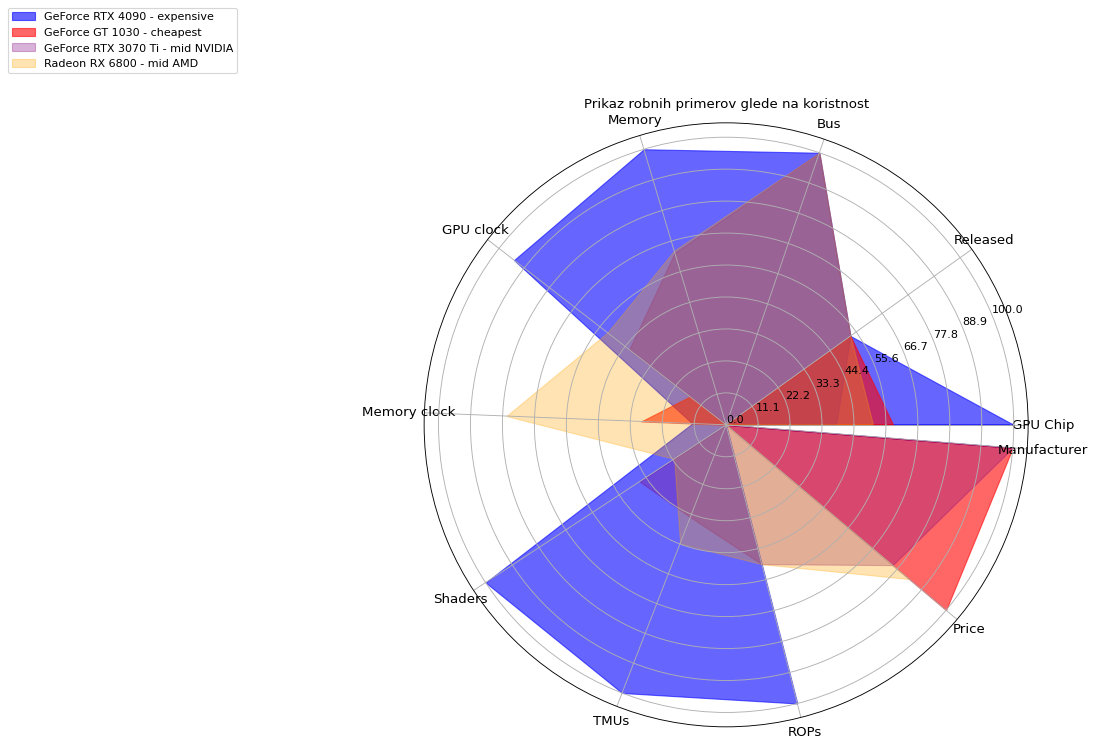

In [250]:
theta = np.linspace(0, 2 * np.pi - 0.08, len(converted_data.columns[1:]))
expensive = converted_data.loc[converted_data['Product Name'] == 'GeForce RTX 4090']
cheapest = converted_data.loc[converted_data['Product Name'] == 'GeForce GT 1030']
mid_nvidia = converted_data.loc[converted_data['Product Name'] == 'GeForce RTX 3070 Ti']
mid_amd = converted_data.loc[converted_data['Product Name'] == 'Radeon RX 6800']
ex, cp, mn, ma = dict(), dict(), dict(), dict()
for i in converted_data.columns[1:]:
    ex[i] = converted_data[converted_data['Product Name'] == 'GeForce RTX 4090'][i].to_list()[0]
    cp[i] = converted_data[converted_data['Product Name'] == 'GeForce GT 1030'][i].to_list()[0]
    mn[i] = converted_data[converted_data['Product Name'] == 'GeForce RTX 3070 Ti'][i].to_list()[0]
    ma[i] = converted_data[converted_data['Product Name'] == 'Radeon RX 6800'][i].to_list()[0]
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111, projection='polar')
ax.fill_between(theta, np.array([v for v in ex.values()], dtype=float), 0, label='GeForce RTX 4090 - expensive', alpha = 0.6, color="blue")
ax.fill_between(theta, np.array([v for v in cp.values()], dtype=float), 0, label='GeForce GT 1030 - cheapest', alpha = 0.6, color="red")
ax.fill_between(theta, np.array([v for v in mn.values()], dtype=float), 0, label='GeForce RTX 3070 Ti - mid NVIDIA', alpha = 0.3, color="purple")
ax.fill_between(theta, np.array([v for v in ma.values()], dtype=float), 0, label='Radeon RX 6800 - mid AMD', alpha = 0.3, color="orange")
ax.set_title("Prikaz robnih primerov glede na koristnost")
ax.set_xticks(theta)
ax.set_rticks(np.linspace(0, 100, 10))
ax.set_xticklabels(converted_data.columns[1:], size=12)
ax.legend(bbox_to_anchor=(-0.3, 1.2))
plt.show()

##### Prikaz uteži

Sledi prikaz hierarhičnega drevesa z uteženimi osnovnimi vozlišči, katerih vrednosti se seštejejo v ena kot je prikazano v poglavju Uteži in funkcije koristnosti - Uteži.
Iz drevesa je razvidno, da ker sem študent, mi je najpomembnejša cena grafične kartice, nato karakteristike čipa grafične kartice, in nato karakteristike spomina. Prav tako ima visoko oceno proizvajalec, saj močno preferiram NVIDIA namesto AMD.

![Weighted hierarchy tree](resources/hierarchy%20tree%20-%20weighted.png)<br>
(Slika 2: Uteženo hierarhično drevo)

### Ocene variant

#### Manjvredne variante

Sledi odstranjevanje manjvrednih variant, torej odstranjevanje variant, ki jih model ne bi izbral nikoli. To sem storil tako, da sem odstranil variante, ki so med boljše
v vsaj eni kategoriji od druge variante.

In [244]:
def remove_inferior(data):
    rows, _ = data.shape
    inferior_variants = set()
    for row1 in range(rows):
        for row2 in range(row1 + 1, rows):
            delta_vector = data.iloc[row1, 1:] - data.iloc[row2, 1:]
            if all(i >= 0 for i in delta_vector):
                inferior_variants.add(data.index[row2])
            if all(i <= 0 for i in delta_vector):
                inferior_variants.add(data.index[row1])
    named_inferior_variants = set()
    for variant in inferior_variants:
        named_inferior_variants.add(data.iloc[variant, 0])
        data = data.iloc[data.index != variant, :] 
    return data, named_inferior_variants

converted_data, inferirors = remove_inferior(converted_data)
print("Inferior variants: ", inferirors)

Inferior variants:  {'GeForce GTX 1660 Ti', 'Radeon RX 6950 XT', 'GeForce RTX 3050 8 GB', 'Radeon RX 6650 XT', 'GeForce GTX 750 Ti', 'GeForce RTX 2070', 'GeForce GTX 1070'}


#### Ocene variant

Ko je bil podatkovni okvir očiščen, in odstranjene manjvredne variante, sem lahko začel z dejanskim ocenjevanjem variant. To sem storil tako, da sem definiral funkcijo, ki izračuna vrednost variante glede na njene koristnosti in uteži kriterijev. Nato sem to funkcijo pognal za vse variante, ki so ostale, in dobil urejen seznam variant. 

In [245]:
def score(variant, weights):
    score = 0
    for k, v in variant.items():
        score += v * weights[k]
    return score

variant_scores = dict()
for variant_name in converted_data['Product Name']:
    variant_dict = dict()
    for column in converted_data[converted_data['Product Name'] == variant_name].columns[1:]:
        variant_dict[column] = converted_data[converted_data['Product Name'] == variant_name][column].to_list()[0]
    variant_scores[variant_name] = round(score(variant_dict, actual_weights), 3)
    
for k, v in sorted(variant_scores.items(), key=lambda x:x[1], reverse=True):
    print(k, ': ', v, sep='')
    

GeForce GTX 1070: 73.716
GeForce GTX 1080 Ti: 72.942
GeForce GTX 1080: 72.093
GeForce RTX 3070: 69.296
GeForce RTX 3060 Ti: 69.234
GeForce RTX 2060 SUPER: 67.89
GeForce RTX 2070: 67.587
GeForce RTX 3060: 67.496
GeForce RTX 3050 8 GB: 67.051
GeForce RTX 2080: 66.834
GeForce RTX 3090: 66.493
GeForce RTX 2060: 66.469
GeForce RTX 3070 Ti: 66.321
GeForce RTX 3080: 65.629
GeForce GTX 1660: 65.048
GeForce GTX 1660 SUPER: 64.982
GeForce GT 1030: 64.723
GeForce GTX 1650: 64.62
GeForce GTX 1660 Ti: 64.456
GeForce RTX 2070 SUPER: 63.488
GeForce GTX 750 Ti: 63.076
GeForce GTX 960: 62.732
GeForce RTX 2080 Ti: 62.128
GeForce RTX 4090: 60.413
Radeon RX 6700 XT: 57.453
Radeon RX 5700 XT: 57.032
Radeon RX 6750 XT: 56.739
Radeon RX 6650 XT: 55.697
Radeon RX 6800 XT: 55.479
Radeon RX 6900 XT: 54.162
Radeon RX 6800: 53.731
GeForce RTX 3090 Ti: 52.633
Radeon RX 6600: 51.505
Radeon RX 6950 XT: 51.333
Radeon RX 5500 XT: 50.991
Radeon RX 580: 48.143


Glede na moje uteži, opisane v prejšnih poglavjih, je razvidno, da so najboljše ocenjene variante starejše grafične kartice, katerim je cena že padla, a so svoje čase veljale za precej zmogljive. Zmagala je namreč grafična kartica NVIDIA GeForce GTX 1070. Zanimivo je, da je grafična kartica GeForce GTX 1080 TI bolje ocenjena kot GeForce 1080, čeprav je dražja. Najvrjetneje je to zato, ker je toliko bolj zmogljiva, da to prevesi višjo ceno. Kljub temu pa so si prve tri variante po točkah precej blizu. 

Na podlagi teh rezultatov sem si za alternativno varianto izbral Radeon RX 6900 XT, saj je ena izmed boljših AMD grafičnih kartic, ki pa so ocenjene slabše kot NVIDIA.

In [246]:
print(converted_data[converted_data['Product Name'] == 'GeForce GTX 1070'].squeeze())
print(converted_data[converted_data['Product Name'] == 'Radeon RX 6900 XT'].squeeze())

Product Name    GeForce GTX 1070
GPU Chip                    78.1
Released                  53.125
Bus                         50.0
Memory                 29.090909
GPU clock               37.35588
Memory clock           76.647834
Shaders                      9.6
TMUs                   19.672131
ROPs                        30.0
Price                  94.951465
Manufacturer                 100
Name: 35, dtype: object
Product Name    Radeon RX 6900 XT
GPU Chip                51.095385
Released                   53.125
Bus                         100.0
Memory                  63.212121
GPU clock                61.87548
Memory clock             76.45951
Shaders                      29.6
TMUs                    60.655738
ROPs                         70.0
Price                   77.803554
Manufacturer                    0
Name: 19, dtype: object


Kot lahko vidimo, ima alternativna varianta dosti boljšo zmogljivost, ampak je dosti slabše ocenjena zaradi višje cene in drugega proizvajalca.

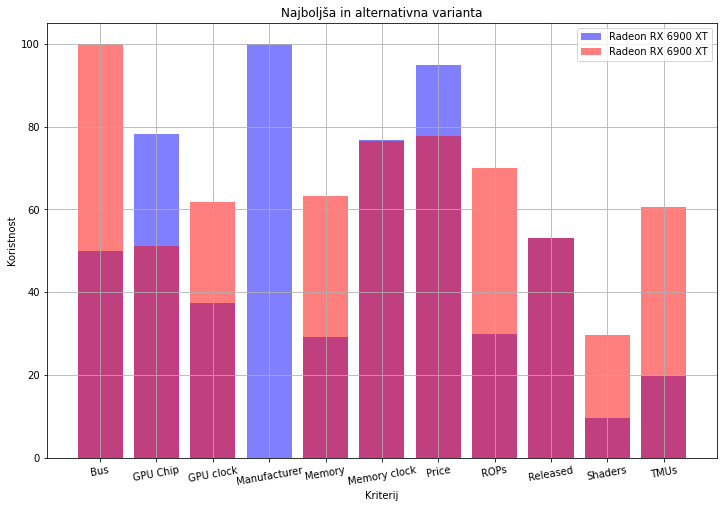

In [261]:
top = converted_data.loc[converted_data['Product Name'] == 'GeForce GTX 1070']
alt = converted_data.loc[converted_data['Product Name'] == 'Radeon RX 6900 XT']

top_dict = dict()
alt_dict = dict()

for column in converted_data.columns[1:]:
    top_dict[column] = top[column].to_list()[0]
    alt_dict[column] = alt[column].to_list()[0]

x1, y1 = zip(*(sorted(top_dict.items())))
x2, y2 = zip(*(sorted(alt_dict.items()))) 

fig, ax = plt.subplots(figsize=(12,8))
plt.grid()
plt.xticks(rotation=10)
#ax.plot(x1, y1, label='GeForce GTX 1070', marker='8', markersize=5, linewidth=2, alpha=0.8, color='b')
#ax.plot(x2, y2, label='Radeon RX 6900 XT', marker='8', markersize=5, linewidth=2, alpha=0.8, color='r')
ax.bar(x1, y1, label='Radeon RX 6900 XT', alpha=0.5, color='b')
ax.bar(x2, y2, label='Radeon RX 6900 XT', alpha=0.5, color='r')
ax.set_title('Najboljša in alternativna varianta')
ax.set_xticks(x2)
ax.set_ylabel('Koristnost')
ax.set_xlabel('Kriterij')
ax.legend(loc=1)
plt.show()

#### Primerjava variant

### Analiza

### Kaj-če analiza

### Zaključki in ugotovitve

### Reference